In [1]:
import os
import glob
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from sklearn.decomposition import PCA
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression
from torch.utils.data import Dataset, DataLoader
import albumentations as A
from albumentations.pytorch import ToTensor
from sklearn.model_selection import train_test_split
from torchvision.models import resnext50_32x4d
import matplotlib.pyplot as plt
from tqdm import trange

integer_to_class = dict(zip([1, 2, 3], ['meningioma', 'glioma', 'pituitary']))

def load_info():
    input_scans = np.load("/content/drive/MyDrive/ColabNotebooks/numpydata/images.npy", allow_pickle=True)
    seg_maps = np.load("/content/drive/MyDrive/ColabNotebooks/numpydata/masks.npy", allow_pickle=True)
    name_scans = np.load("/content/drive/MyDrive/ColabNotebooks/numpydata/labels.npy")
    print(f"images:{input_scans.shape}, masks:{seg_maps.shape}, labels:{name_scans.shape}")
    return np.column_stack((input_scans, seg_maps, name_scans))
info = load_info()

images:(3064,), masks:(3064,), labels:(3064,)


# Now we divide the set into set_training and set_validation

In [3]:
def split_info(info):
    set_training, set_validation = train_test_split(info, test_size=0.08, random_state=42)
    set_training, test_info = train_test_split(set_training, test_size=0.12, random_state=42)
    print("Train:", set_training.shape, "\nVal:", set_validation.shape, "\nTest:", test_info.shape)
    return set_training, set_validation, test_info
set_training, set_validation, test_info = split_info(info)



Train: (2479, 3) 
Val: (246, 3) 
Test: (339, 3)


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

import albumentations as A
from albumentations.pytorch import ToTensor

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

class BT_MRI_Dataset(Dataset):
    def __init__(self, info, modifications, num=3):
        self.info = info
        self.modifications = modifications
        self.num = num
        
    def __len__(self):
        return len(self.info)
    
    def __getitem__(self, x):
        scan = self.info[x][0].astype("float32")
        average, standarddev = scan.mean(), scan.std()
        scan = (scan - average) / standarddev
        scanconv = np.stack([scan]*3).transpose(1,2,0)
        name = self.info[x][2] - 1
        seg_map = np.expand_dims(self.info[x][1], -1)
        
        ground_seg_map = np.zeros((seg_map.shape[0], seg_map.shape[1], 
                                self.num))
        ground_seg_map[:,:, name : name + 1] = seg_map.astype("uint8")
        
        ground_seg_map = np.clip(ground_seg_map, 0, 1).astype("float32")
        
        
        newscan = self.modifications(scan=scanconv, 
                                    seg_map=ground_seg_map)
        scan = newscan['scan']
        seg_map = newscan['seg_map']
        
        return scan, seg_map
def get_modifications():
    return A.Compose([
        A.VerticalFlip(p=0.5),
        A.Rotate(limit=30, p=0.5),
        A.ShiftScaleRotate(scale_limit=0.5, rotate_limit=0, shift_limit=0.1, p=0.5, border_mode=0),
        A.GridDistortion(p=0.5),
        A.OpticalDistortion(p=0.5, distort_limit=2, shift_limit=0.5),
        A.Resize(156, 156, p=1.),
        A.RandomCrop(128, 128, p=1.)
    ])

def create_dataloaders(set_training, set_validation, test_info, modifications):
    set_training = BT_MRI_Dataset(info=set_training, modifications=modifications)
    inputTraining = DataLoader(set_training, batch_size=16, num_workers=4, shuffle=True)

    set_validation = BT_MRI_Dataset(info=set_validation, modifications=modifications)
    inputValidation = DataLoader(set_validation, batch_size=16, num_workers=4, shuffle=True)

    set_test = BT_MRI_Dataset(info=test_info, modifications=modifications)
    inputTest = DataLoader(set_test, batch_size=16, num_workers=4, shuffle=True)

    return inputTraining, inputValidation, inputTest

def apply_pca(dataset, n_components):
    pca = PCA(n_components=n_components)
    flattened_dataset = dataset.reshape(dataset.shape[0], -1)
    transformed_dataset = pca.fit_transform(flattened_dataset)
    return transformed_dataset.reshape(dataset.shape[0], n_components, dataset.shape[2], dataset.shape[3])

n_components = 16
transformed_set_training = apply_pca(set_training, n_components)
transformed_set_validation = apply_pca(set_validation, n_components)
transformed_test_info = apply_pca(test_info, n_components)

inputTraining, inputValidation, inputTest = create_dataloaders(transformed_set_training, transformed_set_validation, transformed_test_info, get_modifications())

# CUSTOM U-NET MODEL

In [13]:
from torchvision.models import resnext50_32x4d

class Convolutional(nn.Module):
    def __init__(self, source, source_out, kernel, padding):
        super().__init__()

        self.convolutional = nn.Sequential(
            nn.Conv2d(source, source_out, kernel, padding=padding),
            nn.ReLU(inplace=True)
        )

    def progress(self, x):
        x = self.convolutional(x)
        return x

class DeLayer(nn.Module):
    def __init__(self, source, source_out):
        super().__init__()
        
        self.conv1 = Convolutional(source, source // 4, 1, 0)
        
        self.deconv = nn.ConvTranspose2d(source // 4, source // 4, kernel_size=4,
                                          stride=2, padding=1, output_padding=0)
        
        self.conv2 = Convolutional(source // 4, source_out, 1, 0)

    def progress(self, x):
        x = self.conv1(x)
        x = self.deconv(x)
        x = self.conv2(x)

        return x

In [14]:
class TransferModel(nn.Module):

    def __init__(self, num):
        super().__init__()
        
        self.base_model = resnext50_32x4d(pretrained=True)
        self.base_layers = list(self.base_model.children())
        filters = [4*64, 4*128, 4*256, 4*512]
        
        self.firsten = nn.Sequential(*self.base_layers[:3])
        self.seconden = nn.Sequential(*self.base_layers[4])
        self.thirden = nn.Sequential(*self.base_layers[5])
        self.fourthen = nn.Sequential(*self.base_layers[6])
        self.fifthen = nn.Sequential(*self.base_layers[7])

        self.firstde = DecoderBlock(filters[3], filters[2])
        self.secondde = DecoderBlock(filters[2], filters[1])
        self.thirdde = DecoderBlock(filters[1], filters[0])
        self.fourthde = DecoderBlock(filters[0], filters[0])

        self.layfirst = ConvRelu(256, 128, 3, 1)
        self.laysecond = nn.Conv2d(128, n_classes, 3, padding=1)
                       
        
    def progress(self, q):
        q = self.firsten(q)
        first = self.seconden(q)
        second = self.thirden(first)
        third = self.fourthen(second)
        fourth = self.fifthen(third)

        fourde = self.firstde(fourth) + third
        threede = self.secondde(fourde) + second
        deetwo = self.thirdde(threede) + first
        deeone = self.fourthde(deetwo)

        put_out = self.layfirst(deeone)
        put_out = self.laysecond(put_out)
        put_out = torch.sigmoid(put_out)
        
        return out

# Performance Metrics


In [15]:
def perf_dice(pred, ground):
    common = 2.0 * (ground * pred).sum()
    commonandelse = ground.sum() + pred.sum()
    if ground.sum() == 0 and pred.sum() == 0:
        return 1.0

    return common / commonandelse

def loss_perf_dice(pred, ground):
    sizelen = ground.size(0)
    pred = pred.reshape(sizelen, -1)
    ground = ground.reshape(sizelen, -1)
    i = 1.0
    common = (pred * ground)
    score = (2. * common.sum(1) + i) / (pred.sum(1) + ground.sum(1) + i)
    score = 1 - score.sum() / sizelen
    return score

def bce_dice_loss(pred, ground):
    dicescore = loss_perf_dice(pred, ground)
    bcescore = nn.BCELoss()
    bceloss = bcescore(pred, ground)

    return bceloss + dicescore

In [16]:
model = TransferModel(num=3).to(device)
adam = torch.optim.Adam(model.parameters(), lr=1e-3)
scheduler = torch.optim.lr_scheduler.StepLR(adam, step_size=10, gamma=0.1)

Downloading: "https://download.pytorch.org/models/resnext50_32x4d-7cdf4587.pth" to /root/.cache/torch/checkpoints/resnext50_32x4d-7cdf4587.pth


# Training

In [17]:
def train(model, optimizer, lr_scheduler, info_loader, epoch):
    model.train()

    losses = []
    accur = []

    for info, ground in info_loader:

        info = info.permute(0,3,1,2).to(device)
        grounds = ground.permute(0,3,1,2).to(device)

        arr = model(info)

        slicearr = np.copy(arr.info.cpu().numpy())
        slicearr[np.nonzero(slicearr < 0.5)] = 0.0
        slicearr[np.nonzero(slicearr >= 0.5)] = 1.0

        trainingcoeffdice = perf_dice(slicearr, grounds.info.cpu().numpy())

        loss = bce_dice_loss(arr, grounds)

        losses.append(loss.item())
        accur.append(trainingcoeffdice)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
    if lr_scheduler is not None:
        lr_scheduler.step()
    return np.array(losses).mean(), np.array(accur).mean()

In [18]:
def validationep(model, valid, epoch, t=0.3):

    model.eval()
    accuracy = []

    with torch.no_grad():
        for info, grounds in valid:

            info = info.permute(0,3,1,2).to(device)
            grounds = grounds.permute(0,3,1,2).to(device)

            arr = model(info)
            np.save("segmentation_output.npy", arr.cpu().numpy())

            slicearr = np.copy(arr.info.cpu().numpy())
            slicearr[np.nonzero(slicearr < t)] = 0.0
            slicearr[np.nonzero(slicearr >= t)] = 1.0

            currdice = perf_dice(slicearr, grounds.info.cpu().numpy())
            accuracy.append(currdice)
        
        return np.array(accuracy).mean()

In [19]:
from tqdm import trange
import os
import glob

direc = "/current"
if os.path.exists(direc) == False:
    os.mkdir(direc)

num_epochs = 30
loss = []
train = []
val = []

for epoch in trange(num_epochs):
    loss, trainingcoeffdice = train(model, adam, scheduler, 
                                       inputTraining, epoch)
    
    currdice = validationsc = validationep(model, inputValidation, epoch)

    loss.append(loss)
    train.append(trainingcoeffdice)
    val.append(currdice)
    most_perform = max(val)
    if currdice >= most_perform:
        torch.save({'state_dict': model.state_dict()},
                   os.path.join(direc, f"{currdice:0.5f}_.pth"))


  0%|          | 0/30 [00:00<?, ?it/s]

Start Train ...
Epoch [0]
Mean loss on train: 0.8868406607258704 Mean DICE on train: 0.18809188886992553
Start Validation ...


  3%|▎         | 1/30 [03:51<1:52:04, 231.88s/it]

Epoch:  0  Threshold:  0.3 Mean Validation DICE Score: 0.3910327030130101
Start Train ...
Epoch [1]
Mean loss on train: 0.678778374771918 Mean DICE on train: 0.41765931290344616
Start Validation ...


  7%|▋         | 2/30 [07:43<1:48:12, 231.88s/it]

Epoch:  1  Threshold:  0.3 Mean Validation DICE Score: 0.38806874717754386
Start Train ...
Epoch [2]
Mean loss on train: 0.5645599513284622 Mean DICE on train: 0.5087220276169558
Start Validation ...


 10%|█         | 3/30 [11:35<1:44:17, 231.76s/it]

Epoch:  2  Threshold:  0.3 Mean Validation DICE Score: 0.4588735423140128
Start Train ...
Epoch [3]
Mean loss on train: 0.5193271212039455 Mean DICE on train: 0.5557373794508683
Start Validation ...


 13%|█▎        | 4/30 [15:26<1:40:25, 231.76s/it]

Epoch:  3  Threshold:  0.3 Mean Validation DICE Score: 0.4808699628666536
Start Train ...
Epoch [4]
Mean loss on train: 0.48370306126533014 Mean DICE on train: 0.5769916482408362
Start Validation ...


 17%|█▋        | 5/30 [19:18<1:36:33, 231.75s/it]

Epoch:  4  Threshold:  0.3 Mean Validation DICE Score: 0.5465712861804505
Start Train ...
Epoch [5]
Mean loss on train: 0.47496157173187503 Mean DICE on train: 0.5854019789684958
Start Validation ...


 20%|██        | 6/30 [23:10<1:32:42, 231.78s/it]

Epoch:  5  Threshold:  0.3 Mean Validation DICE Score: 0.5771653788779472
Start Train ...
Epoch [6]
Mean loss on train: 0.4487904071807861 Mean DICE on train: 0.6101585896808414
Start Validation ...


 23%|██▎       | 7/30 [27:02<1:28:51, 231.83s/it]

Epoch:  6  Threshold:  0.3 Mean Validation DICE Score: 0.5833768361047422
Start Train ...
Epoch [7]
Mean loss on train: 0.46698008804552016 Mean DICE on train: 0.5809230817253287
Start Validation ...


 27%|██▋       | 8/30 [30:54<1:24:58, 231.75s/it]

Epoch:  7  Threshold:  0.3 Mean Validation DICE Score: 0.5691690225820341
Start Train ...
Epoch [8]
Mean loss on train: 0.42822414319361407 Mean DICE on train: 0.6204536589901168
Start Validation ...


 30%|███       | 9/30 [34:45<1:21:05, 231.71s/it]

Epoch:  8  Threshold:  0.3 Mean Validation DICE Score: 0.6190121650954837
Start Train ...
Epoch [9]
Mean loss on train: 0.4045354167299886 Mean DICE on train: 0.6445304765258998
Start Validation ...


 33%|███▎      | 10/30 [38:37<1:17:13, 231.66s/it]

Epoch:  9  Threshold:  0.3 Mean Validation DICE Score: 0.5895149778788965
Start Train ...
Epoch [10]
Mean loss on train: 0.34880484429097947 Mean DICE on train: 0.688763915187435
Start Validation ...


 37%|███▋      | 11/30 [42:29<1:13:22, 231.72s/it]

Epoch:  10  Threshold:  0.3 Mean Validation DICE Score: 0.6752140989614592
Start Train ...
Epoch [11]
Mean loss on train: 0.332891779272787 Mean DICE on train: 0.7074482626581043
Start Validation ...
Epoch:  11  Threshold:  0.3 Mean Validation DICE Score: 0.6992500670007812


 40%|████      | 12/30 [46:22<1:09:37, 232.10s/it]

Start Train ...
Epoch [12]
Mean loss on train: 0.32307068244103465 Mean DICE on train: 0.7200361724232544
Start Validation ...


 43%|████▎     | 13/30 [50:15<1:05:50, 232.40s/it]

Epoch:  12  Threshold:  0.3 Mean Validation DICE Score: 0.6810244765303934
Start Train ...
Epoch [13]
Mean loss on train: 0.31511420694089703 Mean DICE on train: 0.7224010485876754
Start Validation ...


 47%|████▋     | 14/30 [54:07<1:01:59, 232.47s/it]

Epoch:  13  Threshold:  0.3 Mean Validation DICE Score: 0.7172333459843508
Start Train ...
Epoch [14]
Mean loss on train: 0.3144045403888149 Mean DICE on train: 0.7250011410461076
Start Validation ...


 50%|█████     | 15/30 [58:00<58:06, 232.47s/it]  

Epoch:  14  Threshold:  0.3 Mean Validation DICE Score: 0.722489568512733
Start Train ...
Epoch [15]
Mean loss on train: 0.29653892718976543 Mean DICE on train: 0.7371298826274376
Start Validation ...


 53%|█████▎    | 16/30 [1:01:53<54:18, 232.75s/it]

Epoch:  15  Threshold:  0.3 Mean Validation DICE Score: 0.7038710208525826
Start Train ...
Epoch [16]
Mean loss on train: 0.3005875906636638 Mean DICE on train: 0.7362940929995264
Start Validation ...


 57%|█████▋    | 17/30 [1:05:46<50:27, 232.91s/it]

Epoch:  16  Threshold:  0.3 Mean Validation DICE Score: 0.7350758421712491
Start Train ...
Epoch [17]
Mean loss on train: 0.29912470396487945 Mean DICE on train: 0.7334214439491658
Start Validation ...


 60%|██████    | 18/30 [1:09:39<46:33, 232.80s/it]

Epoch:  17  Threshold:  0.3 Mean Validation DICE Score: 0.7108934659652082
Start Train ...
Epoch [18]
Mean loss on train: 0.2958704620599747 Mean DICE on train: 0.742640694191143
Start Validation ...


 63%|██████▎   | 19/30 [1:13:31<42:38, 232.61s/it]

Epoch:  18  Threshold:  0.3 Mean Validation DICE Score: 0.7045202206119542
Start Train ...
Epoch [19]
Mean loss on train: 0.2929396221714635 Mean DICE on train: 0.7373472611397853
Start Validation ...


 67%|██████▋   | 20/30 [1:17:24<38:45, 232.55s/it]

Epoch:  19  Threshold:  0.3 Mean Validation DICE Score: 0.7295045147483252
Start Train ...
Epoch [20]
Mean loss on train: 0.2888526107995741 Mean DICE on train: 0.7400343557430896
Start Validation ...


 70%|███████   | 21/30 [1:21:16<34:52, 232.55s/it]

Epoch:  20  Threshold:  0.3 Mean Validation DICE Score: 0.7248615517220653
Start Train ...
Epoch [21]
Mean loss on train: 0.28517439461523486 Mean DICE on train: 0.7428338650739231
Start Validation ...


 73%|███████▎  | 22/30 [1:25:09<31:00, 232.56s/it]

Epoch:  21  Threshold:  0.3 Mean Validation DICE Score: 0.7050678611379704
Start Train ...
Epoch [22]
Mean loss on train: 0.28882560480025504 Mean DICE on train: 0.7390495362406716
Start Validation ...


 77%|███████▋  | 23/30 [1:29:02<27:08, 232.68s/it]

Epoch:  22  Threshold:  0.3 Mean Validation DICE Score: 0.7337974956020541
Start Train ...
Epoch [23]
Mean loss on train: 0.28144700344531765 Mean DICE on train: 0.7494138204121467
Start Validation ...


 80%|████████  | 24/30 [1:32:54<23:15, 232.56s/it]

Epoch:  23  Threshold:  0.3 Mean Validation DICE Score: 0.7068825549811357
Start Train ...
Epoch [24]
Mean loss on train: 0.28225604733151777 Mean DICE on train: 0.7490707035661296
Start Validation ...
Epoch:  24  Threshold:  0.3 Mean Validation DICE Score: 0.7356243166155318


 83%|████████▎ | 25/30 [1:36:47<19:23, 232.65s/it]

Start Train ...
Epoch [25]
Mean loss on train: 0.2799335860436962 Mean DICE on train: 0.7537377040919989
Start Validation ...


 87%|████████▋ | 26/30 [1:40:41<15:32, 233.00s/it]

Epoch:  25  Threshold:  0.3 Mean Validation DICE Score: 0.7181235806154984
Start Train ...
Epoch [26]
Mean loss on train: 0.2810100248744411 Mean DICE on train: 0.7483134655398348
Start Validation ...


 90%|█████████ | 27/30 [1:44:35<11:39, 233.28s/it]

Epoch:  26  Threshold:  0.3 Mean Validation DICE Score: 0.7055991023248109
Start Train ...
Epoch [27]
Mean loss on train: 0.28739750010351983 Mean DICE on train: 0.748379197014411
Start Validation ...


 93%|█████████▎| 28/30 [1:48:28<07:46, 233.29s/it]

Epoch:  27  Threshold:  0.3 Mean Validation DICE Score: 0.7354111437549302
Start Train ...
Epoch [28]
Mean loss on train: 0.28162133914809073 Mean DICE on train: 0.7544128700911683
Start Validation ...
Epoch:  28  Threshold:  0.3 Mean Validation DICE Score: 0.7426866362643836


 97%|█████████▋| 29/30 [1:52:22<03:53, 233.46s/it]

Start Train ...
Epoch [29]
Mean loss on train: 0.28117037088640273 Mean DICE on train: 0.7509981156707045
Start Validation ...


100%|██████████| 30/30 [1:56:16<00:00, 232.54s/it]

Epoch:  29  Threshold:  0.3 Mean Validation DICE Score: 0.7347289779376257


In [21]:

optwt =  sorted(glob.glob(direc + "/*"),
                       key= lambda x: x[8:-5])[-1]
index = torch.load(optwt)
model.load_state_dict(index['state_dict'])

print(f'Loaded model: {optwt.split("/")[1]}')

Loaded model: 0.74269_.pth


### Train history

In [22]:
def summary(trainwhole,
                       validationwhole,
                       loss ,
                       num_epochs):
    
    x = np.arange(num_epochs)

    fig = plt.figure(figsize=(10, 6))
    plt.plot(x, trainwhole, label='train dice', lw=3, c="springgreen")
    plt.plot(x, validationwhole, label='validation dice', lw=3, c="deeppink")
    plt.plot(x, loss, label='dice + bce', lw=3)

    plt.xlabel("Epoch", fontsize=15)
    plt.ylabel("DICE", fontsize=15)
    plt.legend()

    return plt.show()

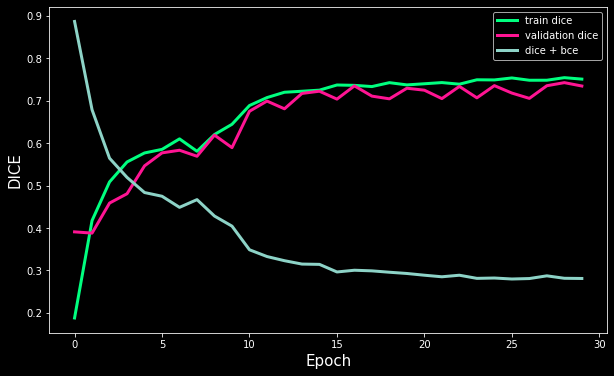

In [23]:
summary(train, val, loss, num_epochs)

### Global IoU with different thresholds

In [25]:
totalSc = []
t = [0.1, 0.2, 0.33, 0.4, 0.5, 0.6, 0.7, 0.8, 0.85, 0.88]
for i in t:
    test_dice = validationep(model, inputTest,t=i, epoch=None)
    totalSc.append(test_dice)

Test Start...
Epoch:  None  Threshold:  0.1 Mean Validation DICE Score: 0.7363348603030573
Test Start...
Epoch:  None  Threshold:  0.2 Mean Validation DICE Score: 0.7479833798260063
Test Start...
Epoch:  None  Threshold:  0.33 Mean Validation DICE Score: 0.7140099009480264
Test Start...
Epoch:  None  Threshold:  0.4 Mean Validation DICE Score: 0.7345780517103926
Test Start...
Epoch:  None  Threshold:  0.5 Mean Validation DICE Score: 0.7148707639506827
Test Start...
Epoch:  None  Threshold:  0.6 Mean Validation DICE Score: 0.7462591513824779
Test Start...
Epoch:  None  Threshold:  0.7 Mean Validation DICE Score: 0.7420782959729931
Test Start...
Epoch:  None  Threshold:  0.8 Mean Validation DICE Score: 0.7367577166769274
Test Start...
Epoch:  None  Threshold:  0.85 Mean Validation DICE Score: 0.7287313167196497
Test Start...
Epoch:  None  Threshold:  0.88 Mean Validation DICE Score: 0.7213372399593714


### Intersection over Union


In [27]:
predicted = []
groundsTrue = []
for data, ground in inputTest:
    with torch.no_grad():
        data = data.permute(0,3,1,2).to(device)
        ground = ground.permute(0,3,1,2)
        prediction = model(data)
        predicted.append(prediction.detach().cpu())
        groundsTrue.append(ground)

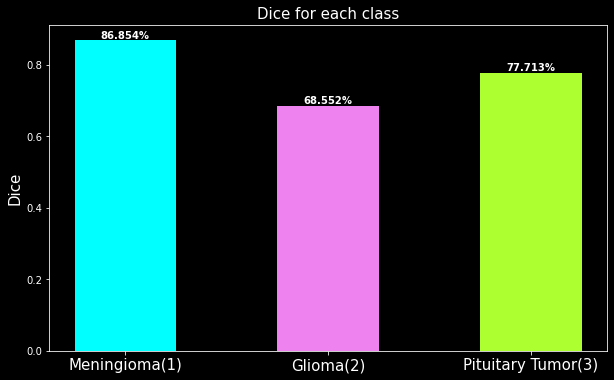

In [29]:

predicted = torch.cat(predicted)
groundsTrue = torch.cat(groundsTrue)
score1 = perf_dice(predicted[:,0,:,:], groundsTrue[:,0,:,:])
score2 = perf_dice(predicted[:,1,:,:], groundsTrue[:,1,:,:])
score3 = perf_dice(predicted[:,2,:,:], groundsTrue[:,2,:,:])
totalSc = [score1, score2, score3]
x = np.arange(3)
totalSc = [score1, score2, score3]
plt.figure(figsize=(10, 6))
plt.bar(x, totalSc, 
        color=["aqua", "violet", "greenyellow"], width=0.5)
                                  
plt.xticks(x, ['Meningioma(1)', 'Glioma(2)', 'Pituitary Tumor(3)'], fontsize=15)
plt.ylabel("Dice", fontsize=15)
plt.title("Dice for each class", fontsize=15)

for curr, curr_in in zip(x, totalSc):
    plt.annotate(f"{curr_in*100:0.3f}%", xy=(curr, curr_in), 
                 rotation=0, color="white", 
                 ha="center", verticalalignment='bottom', 
                 fontsize=10, fontweight="bold")
    
plt.show()

### Random test sample

Text(0.5, 1.0, 'Pituitary tumor')

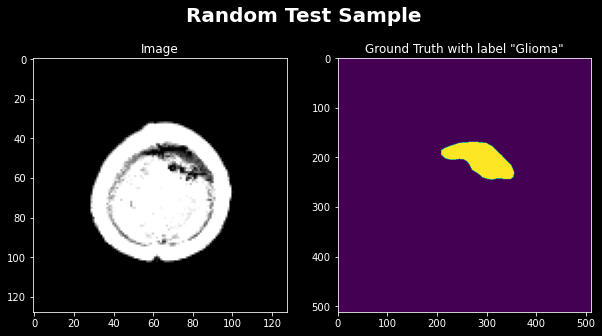

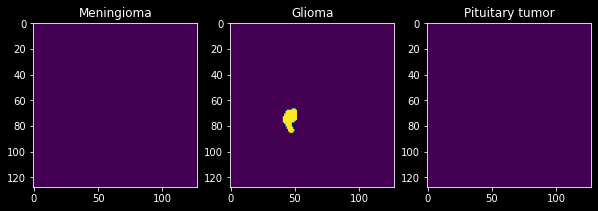

In [31]:
index = np.random.choice(test_info.shape[0], 1, replace=False)

scan = test_info[index][0][0]
avg, standarddev = scan.mean(), scan.std()
scan = (scan - avg) / standarddev  
scan = cv2.resize(scan, (128, 128))
scan = np.stack([scan]*3).transpose(1,2,0)

seg_map = test_info[index][0][1]

name = test_info[index][0][2]

print(scan.shape, seg_map.shape, name)
preds = torch.tensor(scan.astype(np.float32)).unsqueeze(0).permute(0,3,1,2)
preds = model(preds.to(device)).detach().cpu().numpy()
th = 0.4
preds = np.where(preds < th, 0, 255).astype("uint8")

pred_1, pred_2, pred_3 = preds[:, 0, :, :], preds[:, 1, :, :], preds[:, 2, :, :]

fig, ax = plt.subplots(nrows=1,  ncols=2, figsize=(10, 10))

ax[0].imshow(scan)
ax[0].set_title("Image")
ax[1].imshow(seg_map)
ax[1].set_title(f'Ground Truth with label "{integer_to_class[name].capitalize()}"')
plt.suptitle("Random Test Sample",
             y=.75, fontsize=20, weight="bold")
fig, ax = plt.subplots(nrows=1,  ncols=3, figsize=(10, 10))
ax[0].imshow(pred_1[0,:,:])
ax[0].set_title(f'{integer_to_class[1].capitalize()}')
ax[1].imshow(pred_2[0,:,:])
ax[1].set_title(f'{integer_to_class[2].capitalize()}')
ax[2].imshow(pred_3[0,:,:])
ax[2].set_title(f'{integer_to_class[3].capitalize()}')